<a href="https://colab.research.google.com/github/sanagno/psychiatry-mri/blob/eeg/eegreport_one_vs_all.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier as rf
from sklearn.svm import SVC as svm
from sklearn.linear_model import LogisticRegression as lg
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score,balanced_accuracy_score,f1_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from warnings import simplefilter
import os
#import autoencoder as ae
#import importlib
#importlib.reload(ae)
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)


## Clean Data


In [2]:
base_dir = './'

behaviour_data = pd.read_csv(os.path.join(base_dir, 'HBNFinalSummaries.csv'), low_memory=False)

initial_size = behaviour_data.shape[0]
behaviour_data = behaviour_data[behaviour_data['NoDX'].isin(['Yes', 'No'])]
new_size = behaviour_data.shape[0]
print('Removing', initial_size - new_size,
      'patients as their evaluation was incomplete.')

most_common_disorders = ['Attention-Deficit/Hyperactivity Disorder', 'Anxiety Disorders', 'Specific Learning Disorder',
                         'Autism Spectrum Disorder', 'Disruptive', 'No Diagnosis Given', 'Communication Disorder',
                         'Depressive Disorders']

category_columns = ['DX_' + str(i).zfill(2) + '_Cat' for i in range(1, 11)] +\
                   ['DX_' + str(i).zfill(2) + '_Sub' for i in range(1, 11)]

# find users that have no diagnosis within these top diseases
# filtering should cahnge anything as this should also happen at a later stage
mask = None
for col in category_columns:
    mask_col = behaviour_data[col].isin(most_common_disorders)
    if mask is None:
        mask = mask_col
    else:
        mask = mask | mask_col

initial_size = behaviour_data.shape[0]
behaviour_data = behaviour_data[mask]
behaviour_data = behaviour_data.reset_index(drop=True)
new_size = behaviour_data.shape[0]
print('Removing', initial_size - new_size,
      'patients as their diagnoses were very uncommon.')

Removing 282 patients as their evaluation was incomplete.
Removing 73 patients as their diagnoses were very uncommon.


In [0]:
no_diagnosis_given = 'No Diagnosis Given'

if no_diagnosis_given in most_common_disorders:
    no_diag_index = most_common_disorders.index(no_diagnosis_given)
    most_common_disorders = most_common_disorders[:no_diag_index] + \
        most_common_disorders[no_diag_index + 1:]

In [0]:
diagnoses_to_ids = {disorder: i for i, disorder in enumerate(most_common_disorders)}

In [0]:
def get_disorder(data, row, index):
    disorder = data.iloc[row][category_columns[index]]

    if disorder == 'Neurodevelopmental Disorders':
        disorder = data.iloc[row][category_columns[index + 10]]

    return disorder

order_of_disorders = []
for k in range(behaviour_data.shape[0]):
    i = 0
    disorder = get_disorder(behaviour_data, k, i)
    disorders_patient = []
    while disorder != no_diagnosis_given and not pd.isnull(disorder):
        if disorder in diagnoses_to_ids:
            if diagnoses_to_ids[disorder] not in disorders_patient:
                disorders_patient.append(diagnoses_to_ids[disorder])
        i += 1
        if i == len(category_columns):
            break
        disorder = get_disorder(behaviour_data, k, i)

    order_of_disorders.append(disorders_patient)

In [0]:
max_len_order = np.max([len(x) for x in order_of_disorders])

# pad with a new token denoting the pad token
pad_token = len(most_common_disorders)
bod_token = len(most_common_disorders) + 1
eod_token = len(most_common_disorders) + 2

order_of_disorders = [[bod_token] + x + [eod_token] + [pad_token] * (max_len_order - len(x)) for x in order_of_disorders]

order_of_disorders = np.array(order_of_disorders)

In [0]:
classes = np.zeros((len(most_common_disorders),
                    behaviour_data.shape[0]), dtype=np.int32)

df_disorders = behaviour_data[category_columns]

for i, disorder in enumerate(most_common_disorders):
    mask = df_disorders.select_dtypes(include=[object]). \
        applymap(lambda x: disorder in x if pd.notnull(x) else False)

    disorder_df = df_disorders[mask.any(axis=1)]

    np.add.at(classes[i], disorder_df.index.values, 1)

In [0]:
behaviour_data_columns = behaviour_data.columns.values.astype(np.str)

columns_to_drop = behaviour_data_columns[
    np.flatnonzero(np.core.defchararray.find(behaviour_data_columns, 'DX') != -1)]

behaviour_data = behaviour_data.drop(columns=columns_to_drop)

In [0]:
for disorder, classification in zip(most_common_disorders, classes):
    behaviour_data[disorder] = classification

behaviour_data['order_diagnoses'] = list(order_of_disorders)

In [0]:
behaviour_data_id=behaviour_data.EID.values

In [11]:
behaviour_data.shape

(1741, 314)

In [0]:
labels=behaviour_data[["EID"]+list(most_common_disorders)]

In [13]:
labels.head()

,EID,Attention-Deficit/Hyperactivity Disorder,Anxiety Disorders,Specific Learning Disorder,Autism Spectrum Disorder,Disruptive,Communication Disorder,Depressive Disorders
0,NDARYM832PX3,0,1,1,0,0,0,0
1,NDARNJ687DMC,0,0,0,0,0,0,1
2,NDARRM363BXZ,1,0,0,0,0,0,0
3,NDARUW586LLL,0,0,0,0,0,0,1
4,NDARDC298NW4,1,0,0,0,0,0,0


## EEG Data


Electroencephalography (EEG) is an electrophysiological monitoring method to record electrical activity of the brain.

In [0]:
#labels[no_diagnosis_given]=labels[no_diagnosis_given].apply(lambda x:0 if x==1 else 1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
#most_common_disorders=[disorder for disorder in most_common_disorders if disorder!=no_diagnosis_given]

In [14]:
most_common_disorders

['Attention-Deficit/Hyperactivity Disorder',
 'Anxiety Disorders',
 'Specific Learning Disorder',
 'Autism Spectrum Disorder',
 'Disruptive',
 'Communication Disorder',
 'Depressive Disorders']

In [15]:
eeg_mic=pd.read_csv("RestingEEG_Microstates.csv")
eeg_psd=pd.read_csv("RestingEEG_PSD_Average.csv")
eeg_spectro=pd.read_csv("RestingEEG_Spectro_Average.csv")

len(eeg_mic),len(eeg_psd),len(eeg_spectro)


(1108, 1485, 1485)

In [0]:
eeg_mic_labels=pd.merge(eeg_mic,labels,left_on='id',right_on='EID')
eeg_psd_labels=pd.merge(eeg_psd,labels,left_on='id',right_on='EID')
eeg_spectro_labels=pd.merge(eeg_spectro,labels,left_on='id',right_on='EID')

eeg_mic_labels.drop(columns=["EID"],inplace=True)
eeg_psd_labels.drop(columns=["EID"],inplace=True)
eeg_spectro_labels.drop(columns=["EID"],inplace=True)

In [17]:
labels_id=labels.EID.values
beh_full_id=behaviour_data_id.copy()

eeg_mic_id=eeg_mic.id.values

eeg_psd_id=eeg_psd.id.values

eeg_spectro_id=eeg_spectro.id.values

sum_=0
for id in eeg_mic_id:
  if id not in beh_full_id :
    sum_+=1
print("There are ",sum_,"mismatches between the Behavioral Data and the EEG_Mic Data. (Belong to EEG but not to Behavioral)")
    
sum_=0
for id in eeg_mic_id:
  if id not in labels_id :
    sum_+=1
print("There are ",sum_,"mismatches between the Labels and the EEG_Mic Data (Belong to EEG and  but not to Labels).")
print()

sum_=0
for id in eeg_psd_id:
  if id not in beh_full_id :
    sum_+=1
print("There are ",sum_,"mismatches between the Behavioral Data and the EEG_PSD Data (Belong to EEG but not to Behavioral).")
    
sum_=0
for id in eeg_psd_id:
  if id not in labels_id :
    sum_+=1
print("There are ",sum_,"mismatches between the Labels and the EEG_PSD Data (Belong to EEG but not to Labels).")
print()

sum_=0
for id in eeg_spectro_id:
  if id not in beh_full_id :
    sum_+=1
print("There are ",sum_,"mismatches between the Behavioral Data and the EEG_Spectro Data (Belong to EEG but not to Behavioral).")
    
sum_=0
for id in eeg_spectro_id:
  if id not in labels_id :
    sum_+=1
print("There are ",sum_,"mismatches between the Labels and the EEG_Spectro Data (Belong to EEG but not to Labels) .")






There are  180 mismatches between the Behavioral Data and the EEG_Mic Data. (Belong to EEG but not to Behavioral)
There are  180 mismatches between the Labels and the EEG_Mic Data (Belong to EEG and  but not to Labels).

There are  231 mismatches between the Behavioral Data and the EEG_PSD Data (Belong to EEG but not to Behavioral).
There are  231 mismatches between the Labels and the EEG_PSD Data (Belong to EEG but not to Labels).

There are  231 mismatches between the Behavioral Data and the EEG_Spectro Data (Belong to EEG but not to Behavioral).
There are  231 mismatches between the Labels and the EEG_Spectro Data (Belong to EEG but not to Labels) .


In [18]:
print("Microstate: {:5d} Subjects\nPSD: {:12d} Subjects\nSpectro: {:8d} Subjects".\
      format(len(eeg_mic_labels),len(eeg_psd_labels),len(eeg_spectro_labels)))



Microstate:   928 Subjects
PSD:         1254 Subjects
Spectro:     1254 Subjects


In [19]:
#Sanity check for set of EEG Feautures
if(len(set(eeg_mic_id).intersection(set(eeg_psd_id),set(eeg_spectro_id)))==len(eeg_mic_id) and \
   len(set(eeg_psd_id).intersection(set(eeg_spectro_id)))==len(eeg_psd_id)):
  print("Microstate, PSD and Spectro features contain the same subjects.")


Microstate, PSD and Spectro features contain the same subjects.


## Classification


In [0]:
def binary_classifier(x,y,conf_matrix=True,classifiers=['Logistic','Random Forest','SVM'],pca=None,scale=True,n_splits=10,C=20,\
                      return_result=True,verbose=False):

  
  skf=StratifiedKFold(n_splits=n_splits,shuffle=True)
  
  logistic='Logistic' in classifiers
  ranfor='Random Forest' in classifiers
  suve='SVM' in classifiers
  results={}

  
  
  if logistic:
    lgc=lg(C=C,class_weight='balanced',max_iter=1000,solver='lbfgs')
    y_pred_lgc=np.zeros(y.shape[0])
  if ranfor:
    rfc=rf(n_estimators=100,max_depth=5,class_weight='balanced')
    y_pred_rfc=np.zeros(y.shape[0])
  
  if suve:
    
    svmc=svm(C=C,class_weight='balanced')
    y_pred_svmc=np.zeros(y.shape[0])

  for train_index, test_index in skf.split(x, y):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]

        if pca is not None:
          x_train=(x_train-x_train.mean())/x_train.std()
          pca.fit(x_train)
          x_train=pca.transform(x_train)
          x_test=(pca.transform(x_test)-x_train.mean())/x_train.std()

        if scale and (pca is None):
          x_train=(x_train-x_train.mean())/x_train.std()
          x_test=(x_test-x_train.mean())/x_train.std()
        if logistic:
          lgc.fit(x_train, y_train)
          y_pred_lgc[test_index] = lgc.predict(x_test)
        if ranfor:
          rfc.fit(x_train, y_train)
          y_pred_rfc[test_index] = rfc.predict(x_test)
        if suve:
          svmc.fit(x_train, y_train)
          y_pred_svmc[test_index] = svmc.predict(x_test)

  
  if logistic:
    acc=accuracy_score(y,y_pred_lgc)
    bacc=balanced_accuracy_score(y,y_pred_lgc)
    mr=f1_score(y,y_pred_lgc)
    cof_m=confusion_matrix(y,y_pred_lgc)
    if verbose:
      print("Logistic Regression")
      print("-------------------")
      print("Accuracy :",accuracy_score(y,y_pred_lgc))
      print("Balanced Accuracy :",balanced_accuracy_score(y,y_pred_lgc))
      print("f1-score :",f1_score(y,y_pred_lgc))
      if conf_matrix:
        print(confusion_matrix(y,y_pred_lgc))
      print()
    results['log']=[acc,bacc,mr,cof_m]
  if ranfor:
    acc=accuracy_score(y,y_pred_rfc)
    bacc=balanced_accuracy_score(y,y_pred_rfc)
    mr=f1_score(y,y_pred_rfc)
    cof_m=confusion_matrix(y,y_pred_rfc)
    if verbose:
      print("Random Forest")
      print("-----------------")
      print("Accuracy :",accuracy_score(y,y_pred_rfc))
      print("Balanced Accuracy :",balanced_accuracy_score(y,y_pred_rfc))
      print("f1-score :",f1_score(y,y_pred_rfc))
      if conf_matrix:
        print(confusion_matrix(y,y_pred_rfc))
      print()
    results['rf']=[acc,bacc,mr,cof_m]

  if suve:
    acc=accuracy_score(y,y_pred_svmc)
    bacc=balanced_accuracy_score(y,y_pred_svmc)
    mr=f1_score(y,y_pred_svmc)
    cof_m=confusion_matrix(y,y_pred_svmc)
    if verbose:
      print("SVM")
      print("----------------")
      print("Accuracy :",accuracy_score(y,y_pred_svmc))
      print("Balanced Accuracy :",balanced_accuracy_score(y,y_pred_svmc))
      print("f1-score :",f1_score(y,y_pred_svmc))
      if conf_matrix:
        print(confusion_matrix(y,y_pred_svmc))
    results['svm']=[acc,bacc,mr,cof_m]  
  print("Done")
  if return_result:
    return results    

 

In [0]:
def best_classifier(results):
  best={}
  for key_,value in results.items():
    best[key_]=sorted(value,key=lambda x:-x[1])[0]
  return best

def overall_best_result(results):
    best_per_disorder=best_classifier(results)
    results=[]
    for _,value in best_per_disorder.items():
      results.append(value[-1])

    return np.mean(results)



In [0]:
def best_per_disorder(raw_b,pca_b):
  best={}
  for key in raw_b:
    score_raw=raw_b[key][-1]  
    score_pca=pca_b[key][-1]
    
    max_=np.max([score_raw,score_pca])
    max_index=np.argmax([score_raw,score_pca])
    if max_index==0:
      method='raw'
      classifier=raw_b[key][0]
    if max_index==1:
      method='pca'
      classifier=pca_b[key][0]
    best[key]=(method,classifier,max_)
  return best

### EEG Microstates



EEG microstates are transient, patterned, quasi-stable states or patterns of an electroencephalogram. These tend to last anywhere from milliseconds to seconds and are hypothesized to be the most basic instantiations of human neurological tasks, and are thus nicknamed "the atoms of thought".

In [0]:
#y_none=eeg_mic_labels[no_diagnosis_given].values==0
y=eeg_mic_labels[most_common_disorders]

In [0]:
#x=eeg_mic_labels.drop(columns=["id"]+list(most_common_disorders)+[no_diagnosis_given])
x=eeg_mic_labels.drop(columns=["id"]+list(most_common_disorders))
x.fillna(x.mean(axis=0),inplace=True)


In [32]:
x.head()

,eyesclosed_microstates_gevtotal,eyesclosed_microstates_gfp_prototype1,eyesclosed_microstates_gfp_prototype2,eyesclosed_microstates_gfp_prototype3,eyesclosed_microstates_gfp_prototype4,eyesclosed_microstates_occurence_prototype1,eyesclosed_microstates_occurence_prototype2,eyesclosed_microstates_occurence_prototype3,eyesclosed_microstates_occurence_prototype4,eyesclosed_microstates_duration_prototype1,eyesclosed_microstates_duration_prototype2,eyesclosed_microstates_duration_prototype3,eyesclosed_microstates_duration_prototype4,eyesclosed_microstates_coverage_prototype1,eyesclosed_microstates_coverage_prototype2,eyesclosed_microstates_coverage_prototype3,eyesclosed_microstates_coverage_prototype4,eyesclosed_microstates_gev_prototype1,eyesclosed_microstates_gev_prototype2,eyesclosed_microstates_gev_prototype3,eyesclosed_microstates_gev_prototype4,eyesclosed_microstates_mspatcorr_prototype1,eyesclosed_microstates_mspatcorr_prototype2,eyesclosed_microstates_mspatcorr_prototype3,eyesclosed_microstates_mspatcorr_prototype4
0,0.815053,8.594640,7.840168,6.751696,6.155346,4.531579,3.605263,2.042105,1.826316,109.572590,74.712409,59.371134,61.798271,0.496537,0.269358,0.121242,0.112863,0.425801,0.179269,0.050128,0.033547,0.736561,0.707855,0.650813,0.648384
1,0.725810,7.300888,6.125996,5.441025,7.418961,3.929825,2.385965,0.745614,3.421053,118.696429,69.272059,58.470588,94.902564,0.466456,0.165281,0.043596,0.324667,0.305721,0.058535,0.007259,0.176843,0.702696,0.634576,0.491432,0.630921
2,0.727351,11.019322,10.683680,10.461474,10.210294,3.989474,3.515789,3.478947,2.773684,78.812665,71.227545,71.779123,66.857685,0.314421,0.250421,0.249716,0.185442,0.206668,0.148275,0.126315,0.082509,0.680067,0.669293,0.641487,0.608844
3,0.800499,6.234832,6.023094,4.939876,6.024174,3.563158,3.378947,1.710526,4.084211,74.824225,73.489097,66.381538,90.966495,0.266611,0.248316,0.113547,0.371526,0.196817,0.170259,0.045047,0.252637,0.730940,0.722275,0.659675,0.710730
4,0.764762,6.290508,6.239210,5.502705,5.995388,3.463158,3.484211,2.347368,3.189474,85.142857,83.519637,72.278027,76.650165,0.294863,0.291000,0.169663,0.244474,0.203649,0.203309,0.068493,0.139418,0.726088,0.715230,0.654135,0.690053


In [93]:
results_acc_1={}
results_bacc_1={}
results_f1_1={}
results_acc_1_sc={}
results_bacc_1_sc={}
results_f1_1_sc={}

for disorder in y.columns.values:
  print("===============",disorder,"===================")
  #x_=np.concatenate((x[y[disorder]==1].values,x[y_none].values),axis=0)
  x_=np.concatenate((x[y[disorder]==1].values,x[y[disorder]==0].values),axis=0)
  #y_=np.concatenate((np.ones(sum(y[disorder].values==1)),np.zeros(sum(y_none))),axis=0)
  y_=np.concatenate((np.ones(sum(y[disorder].values==1)),np.zeros(sum(y[disorder].values==0))),axis=0)
  print("Number of Subjects: ",y_.shape[0])
  print("Positive: ",sum(y_==1))
  print("Negative: ",sum(y_==0))
  print()
  # scale False
  result=binary_classifier(x_,y_,scale=False)
  
  results_acc_1[disorder]=[]
  results_bacc_1[disorder]=[]
  results_f1_1[disorder]=[]
  for key,value in result.items():
      results_acc_1[disorder].append((key,value[0]))
      results_bacc_1[disorder].append((key,value[1]))
      results_f1_1[disorder].append((key,value[2]))
  print()

  #scale True
  result=binary_classifier(x_,y_,scale=True)
  
  results_acc_1_sc[disorder]=[]
  results_bacc_1_sc[disorder]=[]
  results_f1_1_sc[disorder]=[]
  for key,value in result.items():
      results_acc_1_sc[disorder].append((key,value[0]))
      results_bacc_1_sc[disorder].append((key,value[1]))
      results_f1_1_sc[disorder].append((key,value[2]))
  print()

=============== Attention-Deficit/Hyperactivity Disorder ===================
Number of Subjects:  928
Positive:  559
Negative:  369



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Done

Done

=============== Anxiety Disorders ===================
Number of Subjects:  928
Positive:  213
Negative:  715

Done



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Done

=============== Specific Learning Disorder ===================
Number of Subjects:  928
Positive:  148
Negative:  780



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Done



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Done

=============== Autism Spectrum Disorder ===================
Number of Subjects:  928
Positive:  153
Negative:  775



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Done



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Done

=============== Disruptive ===================
Number of Subjects:  928
Positive:  152
Negative:  776



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Done



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Done

=============== Communication Disorder ===================
Number of Subjects:  928
Positive:  108
Negative:  820



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

Done



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Done

=============== Depressive Disorders ===================
Number of Subjects:  928
Positive:  88
Negative:  840



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Done

Done



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


#### PCA



In [0]:
x=(x-x.mean())/x.std()
pca=PCA().fit(x)

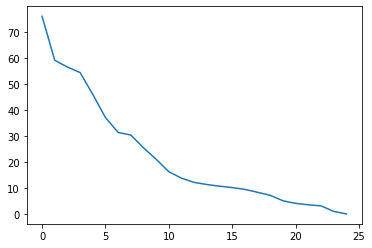

In [0]:
plt.plot(pca.singular_values_)

In [0]:
pca_x=pca.transform(x)[:,:12]

In [52]:
pca_results_acc_1={}
pca_results_bacc_1={}
pca_results_f1_1={}
for disorder in y.columns.values:
  print("===============",disorder,"===================")
  #x_=np.concatenate((pca_x[y[disorder]==1],pca_x[y_none]),axis=0)
  x_=np.concatenate((x[y[disorder]==1],x[y[disorder]==0]),axis=0)
  #y_=np.concatenate((np.ones(sum(y[disorder].values==1)),np.zeros(sum(y_none))),axis=0)
  y_=np.concatenate((np.ones(sum(y[disorder].values==1)),np.zeros(sum(y[disorder]==0))),axis=0)
  print("Number of Subjects: ",y_.shape[0])
  print("Positive: ",sum(y_==1))
  print("Negative: ",sum(y_==0))
  print()
  result=binary_classifier(x_,y_,pca=PCA(n_components=12))
  
  pca_results_acc_1[disorder]=[]
  pca_results_bacc_1[disorder]=[]
  pca_results_f1_1[disorder]=[]
  for key,value in result.items():
      pca_results_acc_1[disorder].append((key,value[0]))
      pca_results_bacc_1[disorder].append((key,value[1]))
      pca_results_f1_1[disorder].append((key,value[2]))

=============== Attention-Deficit/Hyperactivity Disorder ===================
Number of Subjects:  928
Positive:  559
Negative:  369

Done
=============== Anxiety Disorders ===================
Number of Subjects:  928
Positive:  213
Negative:  715



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Done
=============== Specific Learning Disorder ===================
Number of Subjects:  928
Positive:  148
Negative:  780



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Done
=============== Autism Spectrum Disorder ===================
Number of Subjects:  928
Positive:  153
Negative:  775



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Done
=============== Disruptive ===================
Number of Subjects:  928
Positive:  152
Negative:  776



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Done
=============== Communication Disorder ===================
Number of Subjects:  928
Positive:  108
Negative:  820



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Done
=============== Depressive Disorders ===================
Number of Subjects:  928
Positive:  88
Negative:  840

Done


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


### EEG PSD




Power Spectral Densities (PSD): Frequency-wise spectral power from 1-90 Hz.

In [0]:
#y_none=eeg_psd_labels[no_diagnosis_given].values==0
y=eeg_psd_labels[most_common_disorders]

In [0]:
#x=eeg_psd_labels.drop(columns=["id"]+list(most_common_disorders)+[no_diagnosis_given])
x=eeg_psd_labels.drop(columns=["id"]+list(most_common_disorders))

#x.fillna(x.mean(axis=0),inplace=True) No missing values


In [99]:
x.head()

,eyesclosed_psd_01dot00hz_average,eyesclosed_psd_01dot50hz_average,eyesclosed_psd_02dot00hz_average,eyesclosed_psd_02dot50hz_average,eyesclosed_psd_03dot00hz_average,eyesclosed_psd_03dot50hz_average,eyesclosed_psd_04dot00hz_average,eyesclosed_psd_04dot50hz_average,eyesclosed_psd_05dot00hz_average,eyesclosed_psd_05dot50hz_average,eyesclosed_psd_06dot00hz_average,eyesclosed_psd_06dot50hz_average,eyesclosed_psd_07dot00hz_average,eyesclosed_psd_07dot50hz_average,eyesclosed_psd_08dot00hz_average,eyesclosed_psd_08dot50hz_average,eyesclosed_psd_09dot00hz_average,eyesclosed_psd_09dot50hz_average,eyesclosed_psd_10dot00hz_average,eyesclosed_psd_10dot50hz_average,eyesclosed_psd_11dot00hz_average,eyesclosed_psd_11dot50hz_average,eyesclosed_psd_12dot00hz_average,eyesclosed_psd_12dot50hz_average,eyesclosed_psd_13dot00hz_average,eyesclosed_psd_13dot50hz_average,eyesclosed_psd_14dot00hz_average,eyesclosed_psd_14dot50hz_average,eyesclosed_psd_15dot00hz_average,eyesclosed_psd_15dot50hz_average,eyesclosed_psd_16dot00hz_average,eyesclosed_psd_16dot50hz_average,eyesclosed_psd_17dot00hz_average,eyesclosed_psd_17dot50hz_average,eyesclosed_psd_18dot00hz_average,eyesclosed_psd_18dot50hz_average,eyesclosed_psd_19dot00hz_average,eyesclosed_psd_19dot50hz_average,eyesclosed_psd_20dot00hz_average,eyesclosed_psd_20dot50hz_average,...,eyesopen_psd_70dot50hz_average,eyesopen_psd_71dot00hz_average,eyesopen_psd_71dot50hz_average,eyesopen_psd_72dot00hz_average,eyesopen_psd_72dot50hz_average,eyesopen_psd_73dot00hz_average,eyesopen_psd_73dot50hz_average,eyesopen_psd_74dot00hz_average,eyesopen_psd_74dot50hz_average,eyesopen_psd_75dot00hz_average,eyesopen_psd_75dot50hz_average,eyesopen_psd_76dot00hz_average,eyesopen_psd_76dot50hz_average,eyesopen_psd_77dot00hz_average,eyesopen_psd_77dot50hz_average,eyesopen_psd_78dot00hz_average,eyesopen_psd_78dot50hz_average,eyesopen_psd_79dot00hz_average,eyesopen_psd_79dot50hz_average,eyesopen_psd_80dot00hz_average,eyesopen_psd_80dot50hz_average,eyesopen_psd_81dot00hz_average,eyesopen_psd_81dot50hz_average,eyesopen_psd_82dot00hz_average,eyesopen_psd_82dot50hz_average,eyesopen_psd_83dot00hz_average,eyesopen_psd_83dot50hz_average,eyesopen_psd_84dot00hz_average,eyesopen_psd_84dot50hz_average,eyesopen_psd_85dot00hz_average,eyesopen_psd_85dot50hz_average,eyesopen_psd_86dot00hz_average,eyesopen_psd_86dot50hz_average,eyesopen_psd_87dot00hz_average,eyesopen_psd_87dot50hz_average,eyesopen_psd_88dot00hz_average,eyesopen_psd_88dot50hz_average,eyesopen_psd_89dot00hz_average,eyesopen_psd_89dot50hz_average,eyesopen_psd_90dot00hz_average
0,13.252075,13.171060,10.303562,7.247638,5.177531,4.012201,3.257799,2.716654,2.334777,2.064073,1.951010,2.106707,2.599794,3.398925,5.155590,8.938139,12.533943,11.535839,6.956389,3.230759,1.504203,0.841712,0.597280,0.486366,0.416022,0.391247,0.391266,0.386449,0.366163,0.334611,0.294511,0.267583,0.273096,0.293408,0.299024,0.292122,0.284493,0.257461,0.204511,0.160624,...,0.041974,0.041617,0.038385,0.034233,0.032711,0.033877,0.034532,0.033885,0.033288,0.033455,0.033305,0.032292,0.031645,0.033093,0.035101,0.034616,0.033599,0.034358,0.034409,0.032573,0.030488,0.029183,0.029474,0.031485,0.032308,0.030559,0.028891,0.028484,0.028546,0.028926,0.030418,0.032051,0.030983,0.028301,0.028747,0.031572,0.032276,0.031815,0.030898,0.024803
1,18.933153,16.288860,10.595218,6.793446,5.170341,4.259245,3.492614,2.900088,2.419868,2.061413,1.849428,1.643705,1.433840,1.284499,1.148665,0.957932,0.774339,0.713294,0.722093,0.685296,0.611052,0.538792,0.473819,0.421145,0.378297,0.333074,0.284930,0.253142,0.256997,0.264753,0.252979,0.235653,0.220426,0.207347,0.197353,0.196580,0.201940,0.198415,0.186404,0.174339,...,0.017367,0.017632,0.018009,0.017191,0.016044,0.015546,0.015629,0.016328,0.017420,0.018440,0.019046,0.019026,0.018132,0.017376,0.016868,0.016151,0.016245,0.018334,0.020296,0.019596,0.017474,0.015387,0.014524,0.015458,0.017637,0.018725,0.017394,0.015399,0.013978,0.013282,0.013946,0.014787,0.014436,0.013733,0.013491,0.013280,0.012857,0.

In [100]:
results_acc_2={}
results_bacc_2={}
results_f1_2={}
results_acc_2_sc={}
results_bacc_2_sc={}
results_f1_2_sc={}

for disorder in y.columns.values:
  print("===============",disorder,"===================")
  #x_=np.concatenate((x[y[disorder]==1].values,x[y_none].values),axis=0)
  x_=np.concatenate((x[y[disorder]==1].values,x[y[disorder]==0].values),axis=0)
  #y_=np.concatenate((np.ones(sum(y[disorder].values==1)),np.zeros(sum(y_none))),axis=0)
  y_=np.concatenate((np.ones(sum(y[disorder].values==1)),np.zeros(sum(y[disorder].values==0))),axis=0)
  print("Number of Subjects: ",y_.shape[0])
  print("Positive: ",sum(y_==1))
  print("Negative: ",sum(y_==0))
  print()
  # scale False
  result=binary_classifier(x_,y_,scale=False)
  
  results_acc_2[disorder]=[]
  results_bacc_2[disorder]=[]
  results_f1_2[disorder]=[]
  for key,value in result.items():
      results_acc_2[disorder].append((key,value[0]))
      results_bacc_2[disorder].append((key,value[1]))
      results_f1_2[disorder].append((key,value[2]))
  print()

  #scale True
  result=binary_classifier(x_,y_,scale=True)
  
  results_acc_2_sc[disorder]=[]
  results_bacc_2_sc[disorder]=[]
  results_f1_2_sc[disorder]=[]
  for key,value in result.items():
      results_acc_2_sc[disorder].append((key,value[0]))
      results_bacc_2_sc[disorder].append((key,value[1]))
      results_f1_2_sc[disorder].append((key,value[2]))
  print()

=============== Attention-Deficit/Hyperactivity Disorder ===================
Number of Subjects:  1254
Positive:  738
Negative:  516



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

Done



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

Done

=============== Anxiety Disorders ===================
Number of Subjects:  1254
Positive:  301
Negative:  953



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

Done



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

Done

=============== Specific Learning Disorder ===================
Number of Subjects:  1254
Positive:  208
Negative:  1046



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

Done



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

Done

=============== Autism Spectrum Disorder ===================
Number of Subjects:  1254
Positive:  210
Negative:  1044



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

Done



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

Done

=============== Disruptive ===================
Number of Subjects:  1254
Positive:  203
Negative:  1051



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

Done



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

Done

=============== Communication Disorder ===================
Number of Subjects:  1254
Positive:  146
Negative:  1108



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

Done



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

Done

=============== Depressive Disorders ===================
Number of Subjects:  1254
Positive:  114
Negative:  1140



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

Done



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

Done



In [106]:
results_f1_2_sc

{'Anxiety Disorders': [('log', 0.2984218077474893),
  ('rf', 0.0),
  ('svm', 0.26101694915254237)],
 'Attention-Deficit/Hyperactivity Disorder': [('log', 0.0522875816993464),
  ('rf', 0.7116228070175438),
  ('svm', 0.49796582587469485)],
 'Autism Spectrum Disorder': [('log', 0.1044776119402985),
  ('rf', 0.0),
  ('svm', 0.20238095238095236)],
 'Communication Disorder': [('log', 0.16033755274261602),
  ('rf', 0.0),
  ('svm', 0.11764705882352942)],
 'Depressive Disorders': [('log', 0.18400687876182287),
  ('rf', 0.1308411214953271),
  ('svm', 0.20073439412484698)],
 'Disruptive': [('log', 0.2601984564498346),
  ('rf', 0.0),
  ('svm', 0.20679468242245203)],
 'Specific Learning Disorder': [('log', 0.29752066115702475),
  ('rf', 0.0),
  ('svm', 0.2335216572504708)]}

#### PCA


In [0]:
x=(x-x.mean())/x.std()
pca=PCA().fit(x)


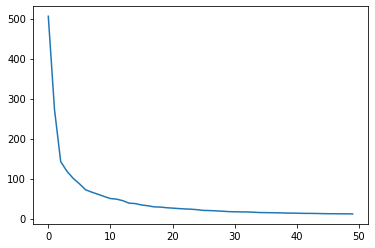

In [0]:
plt.plot(pca.singular_values_[:50])

In [0]:
pca_x=pca.transform(x)[:,:10]

In [60]:
pca_results_acc_2={}
pca_results_bacc_2={}
pca_results_f1_2={}
for disorder in y.columns.values:
  print("===============",disorder,"===================")
  #x_=np.concatenate((pca_x[y[disorder]==1],pca_x[y_none]),axis=0)
  x_=np.concatenate((x[y[disorder]==1],x[y[disorder]==0]),axis=0)
  #y_=np.concatenate((np.ones(sum(y[disorder].values==1)),np.zeros(sum(y_none))),axis=0)
  y_=np.concatenate((np.ones(sum(y[disorder].values==1)),np.zeros(sum(y[disorder]==0))),axis=0)
  print("Number of Subjects: ",y_.shape[0])
  print("Positive: ",sum(y_==1))
  print("Negative: ",sum(y_==0))
  print()
  result=binary_classifier(x_,y_,pca=PCA(n_components=20))
  
  pca_results_acc_2[disorder]=[]
  pca_results_bacc_2[disorder]=[]
  pca_results_f1_2[disorder]=[]
  for key,value in result.items():
      pca_results_acc_2[disorder].append((key,value[0]))
      pca_results_bacc_2[disorder].append((key,value[1]))
      pca_results_f1_2[disorder].append((key,value[2]))

=============== Attention-Deficit/Hyperactivity Disorder ===================
Number of Subjects:  1254
Positive:  738
Negative:  516

Done
=============== Anxiety Disorders ===================
Number of Subjects:  1254
Positive:  301
Negative:  953

Done
=============== Specific Learning Disorder ===================
Number of Subjects:  1254
Positive:  208
Negative:  1046

Done
=============== Autism Spectrum Disorder ===================
Number of Subjects:  1254
Positive:  210
Negative:  1044

Done
=============== Disruptive ===================
Number of Subjects:  1254
Positive:  203
Negative:  1051

Done
=============== Communication Disorder ===================
Number of Subjects:  1254
Positive:  146
Negative:  1108

Done
=============== Depressive Disorders ===================
Number of Subjects:  1254
Positive:  114
Negative:  1140

Done


### EEG Spectro




Spectrogram-based features, such as frequency band, individual alpha power, and FOOOF parameters.



In [0]:
#y_none=eeg_spectro_labels[no_diagnosis_given].values==0
y=eeg_spectro_labels[most_common_disorders]

In [0]:
#x=eeg_spectro_labels.drop(columns=["id"]+list(most_common_disorders)+[no_diagnosis_given])
x=eeg_spectro_labels.drop(columns=["id"]+list(most_common_disorders))

In [64]:
x.shape

(1254, 60)

In [65]:
# proportion of missing values per column with missing values
missing=sum(x.isnull().values)/x.shape[0]
for id,column in enumerate(x.columns.values):
  if (missing[id]>0):
    print(column,": ",missing[id])

eyesclosed_alphapeak_max_freq :  0.1682615629984051
eyesclosed_alphapeak_max_amplitude :  0.1682615629984051
eyesclosed_alphapeak_derivative_freq :  0.15869218500797447
eyesclosed_alphapeak_derivative_amplitude :  0.15869218500797447
eyesclosed_fooof_peak_freq_average :  0.003189792663476874
eyesclosed_fooof_peak_amplitude_average :  0.003189792663476874
eyesopen_alphapeak_max_freq :  0.3277511961722488
eyesopen_alphapeak_max_amplitude :  0.3277511961722488
eyesopen_alphapeak_derivative_freq :  0.2703349282296651
eyesopen_alphapeak_derivative_amplitude :  0.2703349282296651
eyesopen_fooof_peak_freq_average :  0.004784688995215311
eyesopen_fooof_peak_amplitude_average :  0.004784688995215311


In [0]:
x=x.drop(columns=x.columns[missing>0.2])
x.fillna(x.mean(),inplace=True)

In [72]:
results_acc_3={}
results_bacc_3={}
results_f1_3={}
results_acc_3_sc={}
results_bacc_3_sc={}
results_f1_3_sc={}

for disorder in y.columns.values:
  print("===============",disorder,"===================")
  #x_=np.concatenate((x[y[disorder]==1].values,x[y_none].values),axis=0)
  x_=np.concatenate((x[y[disorder]==1].values,x[y[disorder]==0].values),axis=0)
  #y_=np.concatenate((np.ones(sum(y[disorder].values==1)),np.zeros(sum(y_none))),axis=0)
  y_=np.concatenate((np.ones(sum(y[disorder].values==1)),np.zeros(sum(y[disorder].values==0))),axis=0)
  print("Number of Subjects: ",y_.shape[0])
  print("Positive: ",sum(y_==1))
  print("Negative: ",sum(y_==0))
  print()
  #scale false
  result=binary_classifier(x_,y_,scale=False)
  
  results_acc_3[disorder]=[]
  results_bacc_3[disorder]=[]
  results_f1_3[disorder]=[]
  for key,value in result.items():
      results_acc_3[disorder].append((key,value[0]))
      results_bacc_3[disorder].append((key,value[1]))
      results_f1_3[disorder].append((key,value[2]))
  
  #scale true
  result=binary_classifier(x_,y_,scale=True)
  
  results_acc_3_sc[disorder]=[]
  results_bacc_3_sc[disorder]=[]
  results_f1_3_sc[disorder]=[]
  for key,value in result.items():
      results_acc_3_sc[disorder].append((key,value[0]))
      results_bacc_3_sc[disorder].append((key,value[1]))
      results_f1_3_sc[disorder].append((key,value[2]))


=============== Attention-Deficit/Hyperactivity Disorder ===================
Number of Subjects:  1254
Positive:  738
Negative:  516



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

Done
Done
=============== Anxiety Disorders ===================
Number of Subjects:  1254
Positive:  301
Negative:  953



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

Done


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Done
=============== Specific Learning Disorder ===================
Number of Subjects:  1254
Positive:  208
Negative:  1046



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

Done


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Done
=============== Autism Spectrum Disorder ===================
Number of Subjects:  1254
Positive:  210
Negative:  1044



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

Done


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Done
=============== Disruptive ===================
Number of Subjects:  1254
Positive:  203
Negative:  1051



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

Done


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Done
=============== Communication Disorder ===================
Number of Subjects:  1254
Positive:  146
Negative:  1108



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

Done


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Done
=============== Depressive Disorders ===================
Number of Subjects:  1254
Positive:  114
Negative:  1140



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

Done


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Done


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


#### PCA


In [0]:
x=(x-x.mean())/x.std()

In [0]:
pca=PCA().fit(x)

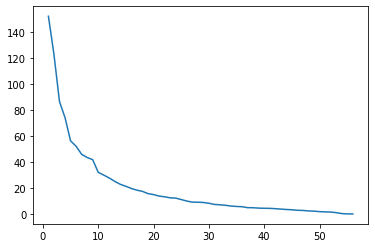

In [0]:
plt.plot(range(1,len(pca.singular_values_[:100])+1),pca.singular_values_[:100])

In [0]:
pca_x=pca.transform(x)[:,:30]

In [110]:
pca_results_acc_3={}
pca_results_bacc_3={}
pca_results_f1_3={}
for disorder in y.columns.values:
  print("===============",disorder,"===================")
  #x_=np.concatenate((pca_x[y[disorder]==1],pca_x[y_none]),axis=0)
  x_=np.concatenate((x[y[disorder]==1],x[y[disorder]==0]),axis=0)
  #y_=np.concatenate((np.ones(sum(y[disorder].values==1)),np.zeros(sum(y_none))),axis=0)
  y_=np.concatenate((np.ones(sum(y[disorder].values==1)),np.zeros(sum(y[disorder]==0))),axis=0)
  print("Number of Subjects: ",y_.shape[0])
  print("Positive: ",sum(y_==1))
  print("Negative: ",sum(y_==0))
  print()
  result=binary_classifier(x_,y_,PCA(n_components=30))
  
  pca_results_acc_3[disorder]=[]
  pca_results_bacc_3[disorder]=[]
  pca_results_f1_3[disorder]=[]
  for key,value in result.items():
      pca_results_acc_3[disorder].append((key,value[0]))
      pca_results_bacc_3[disorder].append((key,value[1]))
      pca_results_f1_3[disorder].append((key,value[2]))

=============== Attention-Deficit/Hyperactivity Disorder ===================
Number of Subjects:  1254
Positive:  738
Negative:  516



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

Done
=============== Anxiety Disorders ===================
Number of Subjects:  1254
Positive:  301
Negative:  953



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

Done
=============== Specific Learning Disorder ===================
Number of Subjects:  1254
Positive:  208
Negative:  1046



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

Done
=============== Autism Spectrum Disorder ===================
Number of Subjects:  1254
Positive:  210
Negative:  1044



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

Done
=============== Disruptive ===================
Number of Subjects:  1254
Positive:  203
Negative:  1051



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

Done
=============== Communication Disorder ===================
Number of Subjects:  1254
Positive:  146
Negative:  1108



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

Done
=============== Depressive Disorders ===================
Number of Subjects:  1254
Positive:  114
Negative:  1140



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

Done


### All together

In [0]:
all=eeg_mic.merge(eeg_psd,how='inner',on='id')
all=all.merge(eeg_spectro,how='inner',on='id')
all_labels=all.merge(labels,how='inner',left_on='id',right_on='EID')

In [0]:
#y_none=all_labels[no_diagnosis_given]==0
y=all_labels[most_common_disorders]
#x=all_labels.drop(columns=["id"]+list(most_common_disorders)+[no_diagnosis_given])
x=all_labels.drop(columns=["id"]+list(most_common_disorders))

x.drop(columns=["EID"],inplace=True)


In [0]:
missing=sum(x.isnull().values)/x.shape[0]
x=x.drop(columns=x.columns[missing>0.2])
x.fillna(x.mean(),inplace=True)

In [85]:
results_acc_all={}
results_bacc_all={}
results_f1_all={}
results_acc_all_sc={}
results_bacc_all_sc={}
results_f1_all_sc={}

for disorder in y.columns.values:
  print("===============",disorder,"===================")
  #x_=np.concatenate((x[y[disorder]==1].values,x[y_none].values),axis=0)
  x_=np.concatenate((x[y[disorder]==1].values,x[y[disorder]==0].values),axis=0)
  #y_=np.concatenate((np.ones(sum(y[disorder].values==1)),np.zeros(sum(y_none))),axis=0)
  y_=np.concatenate((np.ones(sum(y[disorder].values==1)),np.zeros(sum(y[disorder].values==0))),axis=0)
  print("Number of Subjects: ",y_.shape[0])
  print("Positive: ",sum(y_==1))
  print("Negative: ",sum(y_==0))
  print()

  #scale False
  result=binary_classifier(x_,y_,scale=False)
  
  results_acc_all[disorder]=[]
  results_bacc_all[disorder]=[]
  results_f1_all[disorder]=[]
  for key,value in result.items():
      results_acc_all[disorder].append((key,value[0]))
      results_bacc_all[disorder].append((key,value[1]))
      results_f1_all[disorder].append((key,value[2]))
  
  #scale True

  result=binary_classifier(x_,y_,scale=True)
  
  results_acc_all_sc[disorder]=[]
  results_bacc_all_sc[disorder]=[]
  results_f1_all_sc[disorder]=[]
  for key,value in result.items():
      results_acc_all_sc[disorder].append((key,value[0]))
      results_bacc_all_sc[disorder].append((key,value[1]))
      results_f1_all_sc[disorder].append((key,value[2]))



=============== Attention-Deficit/Hyperactivity Disorder ===================
Number of Subjects:  928
Positive:  559
Negative:  369



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

Done
Done
=============== Anxiety Disorders ===================
Number of Subjects:  928
Positive:  213
Negative:  715



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

Done


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Done
=============== Specific Learning Disorder ===================
Number of Subjects:  928
Positive:  148
Negative:  780



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

Done


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Done
=============== Autism Spectrum Disorder ===================
Number of Subjects:  928
Positive:  153
Negative:  775



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

Done


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Done
=============== Disruptive ===================
Number of Subjects:  928
Positive:  152
Negative:  776



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

Done


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Done
=============== Communication Disorder ===================
Number of Subjects:  928
Positive:  108
Negative:  820



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

Done


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Done
=============== Depressive Disorders ===================
Number of Subjects:  928
Positive:  88
Negative:  840



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

Done
Done


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


#### PCA


In [0]:
##PCA
x=(x-x.mean())/x.std()
pca=PCA().fit(x)


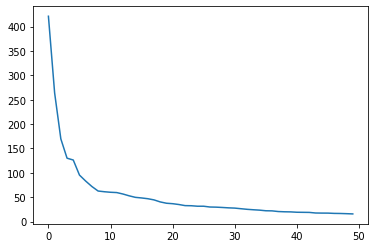

In [0]:
import matplotlib.pyplot as plt
plt.plot(pca.singular_values_[:50])

In [0]:
pca_x=pca.transform(x)[:,:20]

In [111]:
pca_results_acc_all={}
pca_results_bacc_all={}
pca_results_f1_all={}
for disorder in y.columns.values:
  print("===============",disorder,"===================")
  #x_=np.concatenate((pca_x[y[disorder]==1],pca_x[y_none]),axis=0)
  x_=np.concatenate((x[y[disorder]==1],x[y[disorder]==0]),axis=0)
  #y_=np.concatenate((np.ones(sum(y[disorder].values==1)),np.zeros(sum(y_none))),axis=0)
  y_=np.concatenate((np.ones(sum(y[disorder].values==1)),np.zeros(sum(y[disorder]==0))),axis=0)
  print("Number of Subjects: ",y_.shape[0])
  print("Positive: ",sum(y_==1))
  print("Negative: ",sum(y_==0))
  print()
  result=binary_classifier(x_,y_,PCA(n_components=20))
  
  pca_results_acc_all[disorder]=[]
  pca_results_bacc_all[disorder]=[]
  pca_results_f1_all[disorder]=[]
  for key,value in result.items():
      pca_results_acc_all[disorder].append((key,value[0]))
      pca_results_bacc_all[disorder].append((key,value[1]))
      pca_results_f1_all[disorder].append((key,value[2]))

=============== Attention-Deficit/Hyperactivity Disorder ===================
Number of Subjects:  1254
Positive:  738
Negative:  516



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

Done
=============== Anxiety Disorders ===================
Number of Subjects:  1254
Positive:  301
Negative:  953



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

Done
=============== Specific Learning Disorder ===================
Number of Subjects:  1254
Positive:  208
Negative:  1046



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

Done
=============== Autism Spectrum Disorder ===================
Number of Subjects:  1254
Positive:  210
Negative:  1044



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

Done
=============== Disruptive ===================
Number of Subjects:  1254
Positive:  203
Negative:  1051



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

Done
=============== Communication Disorder ===================
Number of Subjects:  1254
Positive:  146
Negative:  1108



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

Done
=============== Depressive Disorders ===================
Number of Subjects:  1254
Positive:  114
Negative:  1140



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

Done


## Results





In [0]:
#Best scores per disorder per disorder
#choose best classifier and method

##Microstates
#best row (scale or not)
best_f1_raw_microst={}
best_f1_raw_no_scale=best_classifier(results_f1_1)
best_f1_raw_scale=best_classifier(results_f1_1_sc)
for key in results_f1_1:
  if best_f1_raw_no_scale[key][1]<best_f1_raw_scale[key][1]:
    best_f1_raw_microst[key]=best_f1_raw_scale[key]
  else:
    best_f1_raw_microst[key]=best_f1_raw_no_scale[key]

#best pca
best_f1_pca_microst=best_classifier(pca_results_f1_1)

#best method (row or pca)
best_f1_per_disorder_microst=best_per_disorder(best_f1_raw_microst,best_f1_pca_microst)


##PSD
#best row (scale or not)
best_f1_raw_psd={}
best_f1_raw_no_scale=best_classifier(results_f1_2)
best_f1_raw_scale=best_classifier(results_f1_2_sc)
for key in results_f1_2:
  if best_f1_raw_no_scale[key][1]<best_f1_raw_scale[key][1]:
    best_f1_raw_psd[key]=best_f1_raw_scale[key]
  else:
    best_f1_raw_psd[key]=best_f1_raw_no_scale[key]

#best pca
best_f1_pca_psd=best_classifier(pca_results_f1_2)

#best method (row or pca)
best_f1_per_disorder_psd=best_per_disorder(best_f1_raw_psd,best_f1_pca_psd)


##Spectro
#best row (scale or not)
best_f1_raw_sp={}
best_f1_raw_no_scale=best_classifier(results_f1_3)
best_f1_raw_scale=best_classifier(results_f1_3_sc)
for key in results_f1_3:
  if best_f1_raw_no_scale[key][1]<best_f1_raw_scale[key][1]:
    best_f1_raw_sp[key]=best_f1_raw_scale[key]
  else:
    best_f1_raw_sp[key]=best_f1_raw_no_scale[key]

#best pca
best_f1_pca_sp=best_classifier(pca_results_f1_3)

#best method (row or pca)
best_f1_per_disorder_sp=best_per_disorder(best_f1_raw_sp,best_f1_pca_sp)


##All Together
#best row (scale or not)
best_f1_raw_all={}
best_f1_raw_no_scale=best_classifier(results_f1_all)
best_f1_raw_scale=best_classifier(results_f1_all_sc)
for key in results_f1_all:
  if best_f1_raw_no_scale[key][1]<best_f1_raw_scale[key][1]:
    best_f1_raw_all[key]=best_f1_raw_scale[key]
  else:
    best_f1_raw_all[key]=best_f1_raw_no_scale[key]

#best pca
best_f1_pca_all=best_classifier(pca_results_f1_all)

#best method (row or pca)
best_f1_per_disorder_all=best_per_disorder(best_f1_raw_all,best_f1_pca_all)


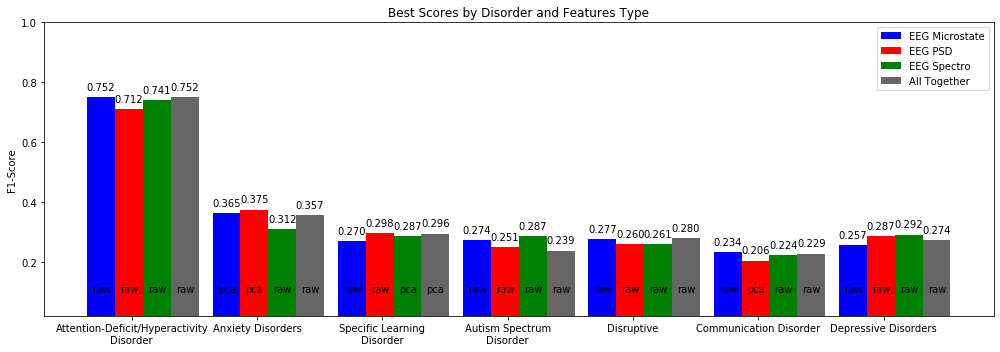

In [163]:
best_micro_=best_f1_per_disorder_microst
best_psd_=best_f1_per_disorder_psd
best_spectro_=best_f1_per_disorder_sp
best_all_together_=best_f1_per_disorder_all

best_micro=[value[-1] for _,value in best_micro_.items()]
best_micro_method=[value[0] for _,value in best_micro_.items()]
best_psd=[value[-1] for _,value in best_psd_.items()]
best_psd_method=[value[0] for _,value in best_psd_.items()]
best_spectro=[value[-1] for _,value in best_spectro_.items()]
best_spectro_method=[value[0] for _,value in best_spectro_.items()]
best_all_together=[value[-1] for _,value in best_all_together_.items()]
best_all_together_method=[value[0] for _,value in best_all_together_.items()]

labels=['Attention-Deficit/Hyperactivity\nDisorder','Anxiety Disorders','Specific Learning\nDisorder','Autism Spectrum\nDisorder',\
        'Disruptive','Communication Disorder','Depressive Disorders']

x = np.arange(len(labels))  # the label locations
width = 1/(3.5+1)  # the width of the bars

fig, ax = plt.subplots(figsize=(14, 5))
rects1 = ax.bar(x , best_micro, width, label='EEG Microstate',color='b',)
rects2 = ax.bar(x+ width , best_psd, width, label='EEG PSD',color='r')
rects3 = ax.bar(x + 2*width, best_spectro, width, label='EEG Spectro',color='g')
rects4= ax.bar(x + 3*width, best_all_together, width, label='All Together',color='black',alpha=0.6)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('F1-Score')
ax.set_title('Best Scores by Disorder and Features Type')
ax.set_xticks(x+1.1*width)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects,best):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for i,rect in enumerate(rects):
        height = rect.get_height()
        ax.annotate('{:.3f}'.format(height),
                    xy=(rect.get_x() + rect.get_width()/2 , height),
                     xytext=(0, 5),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom')
        
        ax.annotate('{:}'.format(best[i]),xy=(rect.get_x() + rect.get_width()/2-0.07 , 0.1))



autolabel(rects1,best_micro_method)
autolabel(rects2,best_psd_method)
autolabel(rects3,best_spectro_method)
autolabel(rects4,best_all_together_method)


plt.ylim([0.02, 1])



fig.tight_layout()


plt.show()


